# Implementação de Features e Avaliação do Modelo

Este notebook implementa novas features para melhorar as previsões de PM2.5 e avalia a importância de cada feature.

In [26]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import date, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.preprocessing import OneHotEncoder

In [27]:
# Configurar a conexão ao PostgreSQL
USER = "postgres"
PASSWORD = "password"
HOST = "localhost"
PORT = "5432"
DB_NAME = "db_measurements"

# Criar a string de conexão
conn_str = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}"

# Criar a engine de conexão
engine = create_engine(conn_str)

# Carregar dados
query = "SELECT * FROM tbl_weather_history"
df_weather_history = pd.read_sql(query, engine)

query = "SELECT * FROM tbl_measurements"
df_measurements = pd.read_sql(query, engine)

In [28]:
df_measurements.head()

,id,id_sensor,ds_city,dt_date_from,dt_date_to,qt_pm25
0,1,491,Puerto Montt,2024-03-26 03:00:00,2024-03-27 03:00:00,14.0
1,2,491,Puerto Montt,2024-03-27 03:00:00,2024-03-28 03:00:00,14.2
2,3,491,Puerto Montt,2024-03-28 03:00:00,2024-03-29 03:00:00,30.4
3,4,491,Puerto Montt,2024-03-29 03:00:00,2024-03-30 03:00:00,18.1
4,5,491,Puerto Montt,2024-03-30 03:00:00,2024-03-31 03:00:00,24.1


In [29]:
# Preparar os dados
df_weather_history["dt_date"] = pd.to_datetime(df_weather_history["dt_date"])
df_measurements["dt_date_from"] = pd.to_datetime(df_measurements["dt_date_from"])
df_weather_history['dt_date'] = df_weather_history['dt_date'].apply(lambda x: x.date().isoformat() if pd.notnull(x) else None)
df_measurements['dt_date'] = df_measurements['dt_date_from'].apply(lambda x: x.date().isoformat() if pd.notnull(x) else None)

# Merge dos dataframes
df = pd.merge(df_weather_history, df_measurements, on=['ds_city', 'dt_date'], how='inner')

# Drop de colunas desnecessárias
df.drop(columns=['id_x', 'id_y', 'id_sensor', 'dt_date_from', 'dt_date_to'], inplace=True)

# Média de PM2.5 por cidade e data
df = df.groupby(['ds_city', 'dt_date']).mean().reset_index()

# One Hot Encoding para cidade
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df[['ds_city']]).toarray()
df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['ds_city']))
df = pd.concat([df, df_encoded], axis=1)

In [30]:
# Ordenar os dados por cidade e data
df = df.sort_values(['ds_city', 'dt_date'])

# Criar médias móveis para diferentes períodos
df['qt_pm25_ma3'] = df.groupby('ds_city')['qt_pm25'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['qt_pm25_ma7'] = df.groupby('ds_city')['qt_pm25'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['qt_pm25_ma14'] = df.groupby('ds_city')['qt_pm25'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())
df['qt_pm25_ema'] = df.groupby('ds_city')['qt_pm25'].transform(lambda x: x.ewm(span=7, adjust=False).mean())
df['qt_pm25_std7'] = df.groupby('ds_city')['qt_pm25'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
df['qt_pm25_trend'] = df['qt_pm25_ma7'] - df['qt_pm25_ma3']

# Features de sazonalidade
df['dia_semana'] = pd.to_datetime(df['dt_date']).dt.dayofweek
df['mes_ano'] = pd.to_datetime(df['dt_date']).dt.month
df['estacao'] = pd.to_datetime(df['dt_date']).dt.month % 12 // 3 + 1

# Features de interação
df['temp_umidade'] = df['qt_avg_temp_c'] * df['qt_avg_humidity']
df['pressao_umidade'] = df['qt_pressure_mb'] * df['qt_avg_humidity']
df['vento_umidade'] = df['qt_max_wind_kph'] * df['qt_avg_humidity']

# Remover linhas com valores NaN
df = df.dropna()

In [31]:
df.head()

,ds_city,dt_date,qt_avg_humidity,qt_avg_temp_c,qt_avg_vis_km,qt_max_wind_kph,qt_total_precip_mm,qt_pressure_mb,qt_pm25,ds_city_Puerto Montt,...,qt_pm25_ma14,qt_pm25_ema,qt_pm25_std7,qt_pm25_trend,dia_semana,mes_ano,estacao,temp_umidade,pressao_umidade,vento_umidade
1,Puerto Montt,2024-03-29,78.0,12.5,8.7,15.8,3.20,1020.08,17.95,1.0,...,23.525000,26.312500,7.884241,0.000000,4,3,2,975.0,79566.24,1232.4
2,Puerto Montt,2024-03-30,75.0,10.1,8.7,11.5,1.50,1024.50,24.55,1.0,...,23.866667,25.871875,5.606321,0.000000,5,3,2,757.5,76837.50,862.5
3,Puerto Montt,2024-03-31,73.0,9.2,10.0,13.3,0.00,1023.04,26.15,1.0,...,24.437500,25.941406,4.717763,1.554167,6,3,2,671.6,74681.92,970.9
4,Puerto Montt,2024-04-01,72.0,9.1,10.0,8.3,0.00,1019.50,43.75,1.0,...,28.300000,30.393555,9.554449,-3.183333,0,4,2,655.2,73404.00,597.6
5,Puerto Montt,2024-04-02,87.0,10.2,8.3,43.6,30.88,1002.88,30.10,1.0,...,28.600000,30.320166,8.577296,-4.733333,1,4,2,887.4,87250.56,3793.2


In [32]:
# Definir features para o modelo
features = [
    'qt_avg_humidity', 'qt_avg_temp_c', 'qt_avg_vis_km', 
    'qt_max_wind_kph', 'qt_total_precip_mm', 'qt_pressure_mb',
    'qt_pm25_ma3', 'qt_pm25_ma7', 'qt_pm25_ma14',
    'qt_pm25_ema', 'qt_pm25_std7', 'qt_pm25_trend',
    'dia_semana', 'mes_ano', 'estacao',
    'temp_umidade', 'pressao_umidade', 'vento_umidade'
] + [col for col in df.columns if col.startswith('ds_city_')]

# Separar features e target
X = df[features]
y = df['qt_pm25']

# Split dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R2 Score: {r2:.4f}')

Mean Squared Error: 147.6047
R2 Score: 0.7655


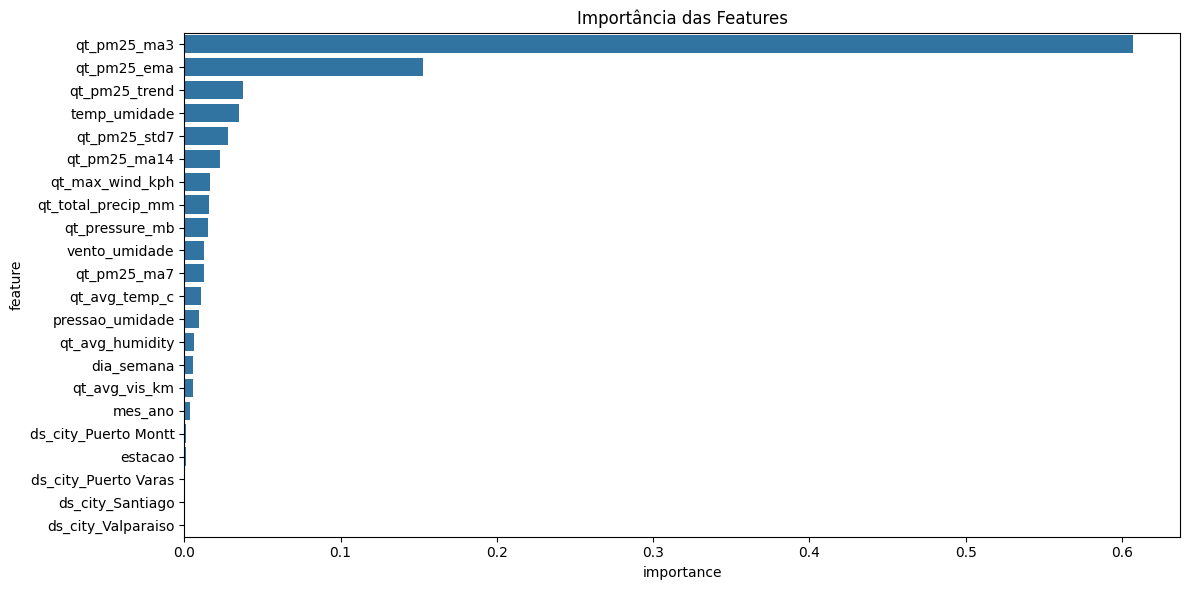

In [33]:
# Avaliar importância das features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plotar importância das features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features')
plt.tight_layout()
plt.show()

In [34]:
# Salvar o modelo treinado
joblib.dump(model, 'model.pkl')

['model.pkl']